In [1]:
import torch
import datetime
import torch.nn as nn
import pandas as pd
from torch.autograd import Variable
from apollo import mechanics as ma
from apollo import streamflow as sf
from apollo import metrics as me

In [2]:
### Set global model parameters
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
station = 33039
filename = str(str(station) + '_lumped.csv')
rf = pd.read_csv(filename)
rf['Date'] = pd.to_datetime(rf['Date'], format='%Y-%m-%d').dt.date
#rf = rf.drop(rf.index[:552])
rf = rf.dropna(subset=['Flow'])
rf

,Unnamed: 0,Date,Flow,Temperature,U Windspeed,V Windspeed,Humidity,Rain,Resultant Windspeed,Rain-1,...,Humidity-25,Humidity-26,Humidity-27,Humidity_28_Mu,Humidity_90_Mu,Humidity_180_Mu,Soil Moisture 1,Soil Moisture 2,Soil Moisture 3,Soil Moisture 4
0,179,1979-06-29,5.45,286.376161,6.800205,-1.437941,58.208029,0.072360,6.950573,0.087897,...,80.461665,87.589760,79.231239,66.008818,66.263716,73.356070,0.392431,0.400839,0.416691,0.479503
1,180,1979-06-30,5.52,285.086251,6.608684,-4.065574,64.863250,0.407522,7.759098,0.072360,...,65.968501,80.461665,87.589760,65.495676,66.306163,73.328625,0.385454,0.397272,0.415453,0.479213
2,181,1979-07-01,5.25,285.443355,3.967978,-5.207054,53.635134,0.061370,6.546622,0.407522,...,51.195369,65.968501,80.461665,64.283011,66.140067,73.283940,0.377821,0.393451,0.414128,0.478914
3,182,1979-07-02,4.98,287.577603,2.465023,-2.705265,61.548741,0.019252,3.659890,0.061370,...,78.352533,51.195369,65.968501,63.607549,65.882094,73.218692,0.369251,0.389358,0.412725,0.478600
4,183,1979-07-03,5.24,289.201504,1.652422,-1.771162,62.364322,0.008066,2.422295,0.019252,...,54.622342,78.352533,51.195369,63.478828,65.914969,73.146729,0.361340,0.385199,0.411296,0.478287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15522,15701,2021-12-27,39.55,282.165278,-3.114224,1.804984,98.709620,2.741783,3.599494,8.926635,...,66.799492,73.634855,87.051938,87.655628,81.074843,73.756284,0.479203,0.484323,0.493564,0.454945
15523,15702,2021-12-28,41.93,283.773367,7.232938,-0.353079,84.615832,5.696018,7.241551,2.741783,...,93.715812,66.799492,73.634855,87.568625,81.297546,73.848343,0.473548,0.500949,0.496018,0.455852
15524,15703,2021-12-29,41.97,287.732271,5.270986,4.206975,93.465318,2.206835,6.744030,5.696018,...,76.269427,93.715812,66.799492,88.276855,81.510355,73.964107,0.492404,0.492179,0.495774,0.457004
15525,15704,2021-12-30,36.65,286.914355,3.766243,4.395763,92.862960,0.079345,5.788551,2.206835,...,87.020351,76.269427,93.715812,89.207694,81.774445,74.078624,0.480940,0.488513,0.494958,0.458042


In [36]:
### Identify features (with either antecedent proxies or soil moisture levels)
days = 6
features = ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] \
            + ['Temperature'] \
            + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Resultant Windspeed'] \
            + ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            + ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)] \
            + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']
            # ['Soil Moisture ' + f'{i+1}' for i in range(4)]
targets = ['Flow']
xspace = ma.featurelocator(rf, features)
yspace = ma.featurelocator(rf, targets)

In [37]:
###Test/Train data split by years
yearlist = [2010+i for i in range(12)]
rftrain = rf[~pd.to_datetime(rf['Date']).dt.year.isin(yearlist)]
rftrain

,Unnamed: 0,Date,Flow,Temperature,U Windspeed,V Windspeed,Humidity,Rain,Resultant Windspeed,Rain-1,...,Humidity-25,Humidity-26,Humidity-27,Humidity_28_Mu,Humidity_90_Mu,Humidity_180_Mu,Soil Moisture 1,Soil Moisture 2,Soil Moisture 3,Soil Moisture 4
0,179,1979-06-29,5.45,286.376161,6.800205,-1.437941,58.208029,0.072360,6.950573,0.087897,...,80.461665,87.589760,79.231239,66.008818,66.263716,73.356070,0.392431,0.400839,0.416691,0.479503
1,180,1979-06-30,5.52,285.086251,6.608684,-4.065574,64.863250,0.407522,7.759098,0.072360,...,65.968501,80.461665,87.589760,65.495676,66.306163,73.328625,0.385454,0.397272,0.415453,0.479213
2,181,1979-07-01,5.25,285.443355,3.967978,-5.207054,53.635134,0.061370,6.546622,0.407522,...,51.195369,65.968501,80.461665,64.283011,66.140067,73.283940,0.377821,0.393451,0.414128,0.478914
3,182,1979-07-02,4.98,287.577603,2.465023,-2.705265,61.548741,0.019252,3.659890,0.061370,...,78.352533,51.195369,65.968501,63.607549,65.882094,73.218692,0.369251,0.389358,0.412725,0.478600
4,183,1979-07-03,5.24,289.201504,1.652422,-1.771162,62.364322,0.008066,2.422295,0.019252,...,54.622342,78.352533,51.195369,63.478828,65.914969,73.146729,0.361340,0.385199,0.411296,0.478287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11139,11318,2009-12-27,30.50,278.994992,6.331817,0.568189,77.580395,0.079413,6.357260,0.295804,...,88.242235,87.117446,84.912958,87.144734,80.495692,72.850994,0.486368,0.485747,0.472367,0.444858
11140,11319,2009-12-28,25.00,275.831436,-1.638468,0.092786,88.500687,0.001205,1.641093,0.079413,...,85.085062,88.242235,87.117446,87.272867,80.735143,73.105194,0.477898,0.483240,0.473026,0.445121
11141,11320,2009-12-29,20.80,276.045712,-5.216992,-2.120879,95.079281,14.030142,5.631619,0.001205,...,79.636077,85.085062,88.242235,87.557219,81.007283,73.336721,0.500182,0.481136,0.473389,0.445382
11142,11321,2009-12-30,37.30,275.838858,-3.923440,-2.532168,96.590872,8.169803,4.669610,14.030142,...,87.033345,79.636077,85.085062,87.855384,81.417070,73.423494,0.513234,0.509891,0.478454,0.445697


In [39]:
### Normalise features using parameters cached from the training set
norm_cache = {}
for f in features:
    rftrain[f] = ma.normalise(rftrain, f, norm_cache, write_cache=True)
    rf[f] = ma.normalise(rf, f, norm_cache, write_cache=False)

C:\Users\aline\AppData\Local\Temp\ipykernel_41464\430038725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rftrain[f] = ma.normalise(rftrain, f, norm_cache, write_cache=True)


In [40]:
rftrain['Date'] = rftrain['Date'].apply(lambda x: datetime.datetime.combine(x, datetime.datetime.min.time()).timestamp())
rf['Date'] = rf['Date'].apply(lambda x: datetime.datetime.combine(x, datetime.datetime.min.time()).timestamp())

C:\Users\aline\AppData\Local\Temp\ipykernel_41464\2346790958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rftrain['Date'] = rftrain['Date'].apply(lambda x: datetime.datetime.combine(x, datetime.datetime.min.time()).timestamp())


In [41]:
### Convert dataframe subsets to arrays and then to PyTorch variables
trnset = rftrain.to_numpy()
fullset = rf.to_numpy()
X = trnset[:,xspace].reshape(len(trnset), len(xspace)).astype(float)
Y = trnset[:,yspace].reshape(len(trnset), 1).astype(float)
x = torch.from_numpy(X).to(device)
y = torch.from_numpy(Y).to(device)
x, y = Variable(x), Variable(y)

In [42]:
### Define Neural Network structure and initialisation procedure
class AntecedentNET(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(AntecedentNET, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear_layers = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.SiLU(),
            nn.Linear(64, 16),
            nn.SiLU(),
            nn.Linear(16, 1),
            )
    
    def forward(self, z):
        z = self.linear_layers(z)
        return z

In [43]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

In [44]:
### Network initialisation
net = AntecedentNET(len(xspace), len(yspace))
net = nn.DataParallel(net)
net.apply(init_weights)

DataParallel(
  (module): AntecedentNET(
    (linear_layers): Sequential(
      (0): Linear(in_features=34, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
      (3): SiLU()
      (4): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)

In [46]:
### Network training
net = net.train()
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.2)
loss_func = torch.nn.MSELoss()
loss_list = []
for i in range(5000):
    y_pred = net(x.float())
    loss = loss_func(y_pred, y.float())
    net.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.data)
    if(i % 500 == 0):
        print('epoch {}, loss {}'.format(i, loss.data))

epoch 0, loss 56.84174728393555
epoch 500, loss 47.21045684814453
epoch 1000, loss 44.68820571899414
epoch 1500, loss 43.918216705322266
epoch 2000, loss 42.79941177368164
epoch 2500, loss 40.466278076171875
epoch 3000, loss 39.3475341796875
epoch 3500, loss 39.023441314697266
epoch 4000, loss 38.84437561035156
epoch 4500, loss 38.738277435302734


In [47]:
### Evaluate Network
net = net.eval()
Z = fullset[:,xspace].reshape(len(fullset), len(xspace)).astype(float)
z = torch.from_numpy(Z).to(device)
predicted = net(z.float()).data.cpu().numpy()
rf['Predicted'] = predicted

if rf['Date'].dtype == 'float64':
    rf['Date'] = pd.to_datetime(rf['Date'], unit='s').dt.date
maxflow = 300
testrf = rf[pd.to_datetime(rf['Date']).dt.year.isin(yearlist)]
testrf[['Flow', 'Predicted']]

,Flow,Predicted
11144,49.00,46.721565
11145,44.70,34.870888
11146,23.20,21.860785
11147,17.30,16.233944
11148,14.80,11.161992
...,...,...
15522,39.55,49.430027
15523,41.93,54.676754
15524,41.97,53.354485
15525,36.65,47.780048


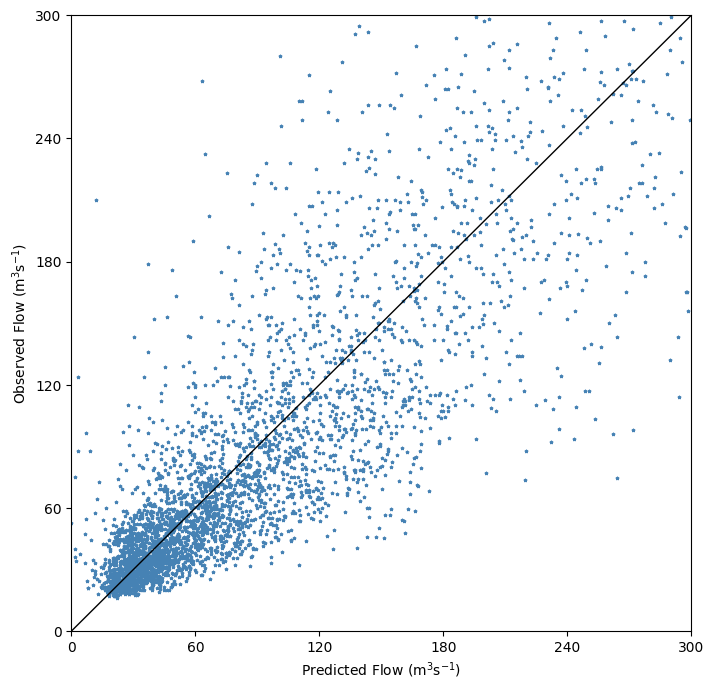

- - - - - - - - - - - - - - -
RMSE: nan
R²: nan


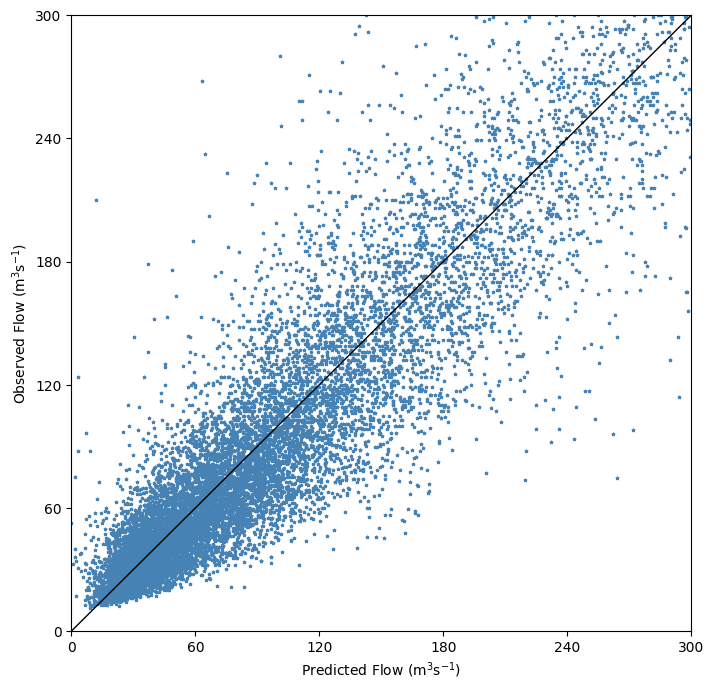

- - - - - - - - - - - - - - -
RMSE: nan
R²: nan


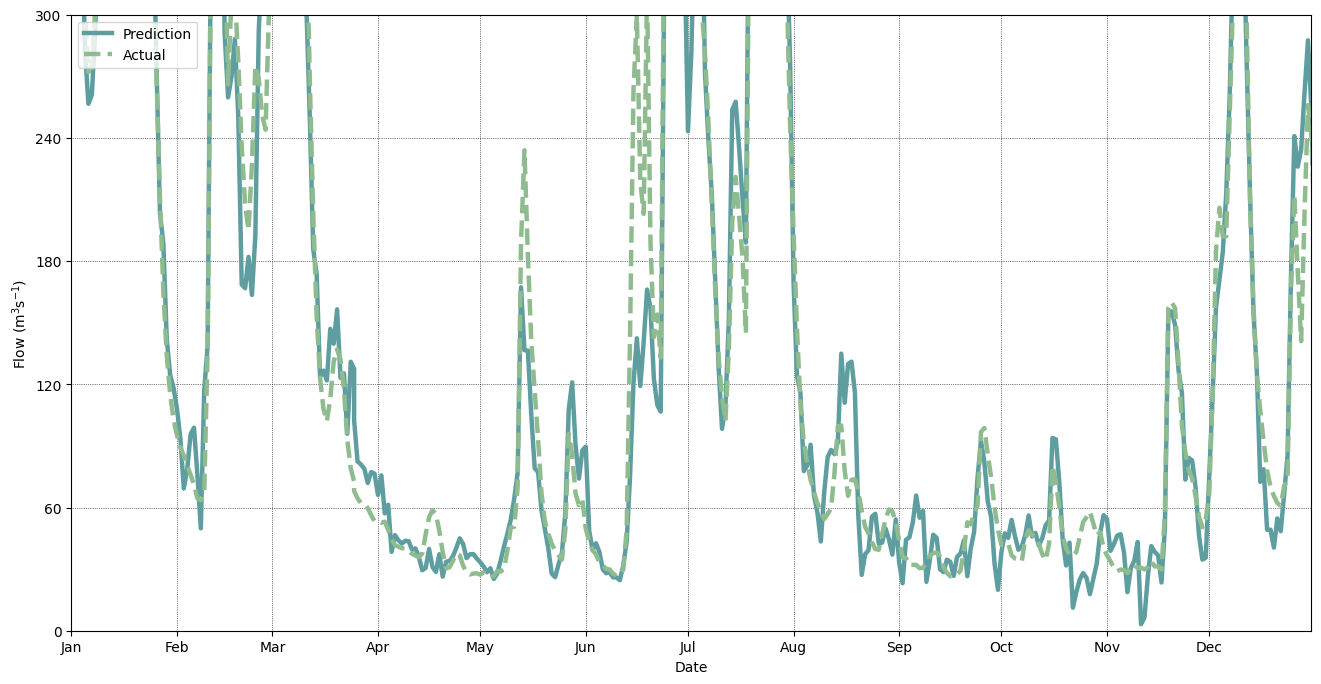

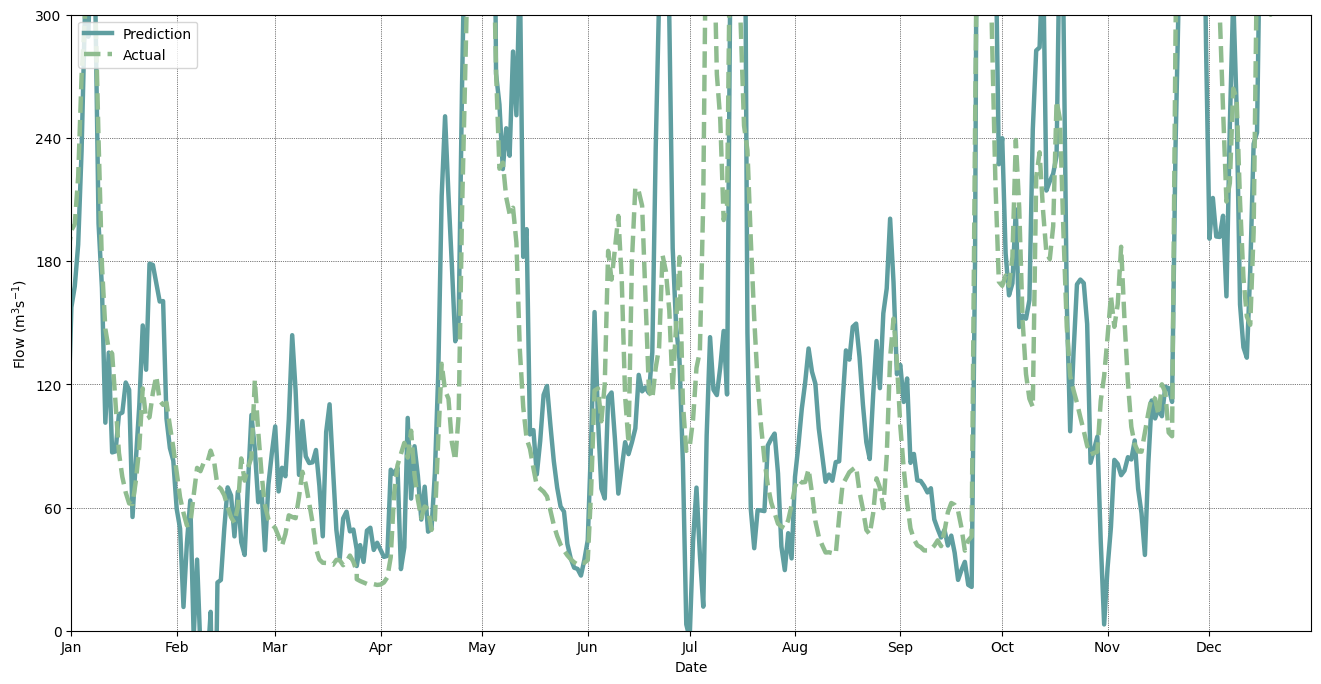

In [59]:
for df in (testrf, rf):
    sf.scatter_plot(maxflow, df, 'Predicted', 'Flow')
    print('- - - - - - - - - - - - - - -')
    print('RMSE: ' + str(me.RMSE(df['Flow'], df['Predicted'])))
    print('R\N{SUPERSCRIPT TWO}: ' + str(me.R2(df['Flow'], df['Predicted'])))
sf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2007)
sf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2012)